The code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. 

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

## Colab

In [ ]:
# Mount your google drive (currently not required)
# from google.colab import drive
# drive.mount('/content/drive')

## Imports

In [ ]:
!pip install torchdiffeq

In [1]:
# import autograd
# import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader,random_split
import torch

from torchdiffeq import odeint_adjoint as odeint_adjoint # func needs to be nn.Module for odeint_adjoint to work
from torchdiffeq import odeint as odeint

import time as time

In [2]:
# set device to GPU if available otherwise use CPU
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Device Availble: {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device
    
device = set_device()

cpu


## Data Generation

Similar to https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

### Plots

In [3]:
def plot_traj_pend(t_eval, q, p, energy=torch.tensor(False), coord_type = 'hamiltonian'):
    '''
    This function plots the generalised variable q p in function of the evaluation 
    time
    Inputs:
      t_eval ()
      q ()
      p ()
    Outputs:
      None
    '''
    if torch.any(energy):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4),constrained_layout=True)#, sharex=True)# , sharey=True)
        ax3.plot(t_eval, energy, label='energy')

        #ax1.legend()
        ax3.set_title('Energy', fontsize=10)
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('E')
        ax3.set_ylim((0,torch.max(energy)*1.1))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),constrained_layout=True, sharex=True)# , sharey=True)


    ax1.plot(t_eval, q, label='q')
    ax2.plot(t_eval, p, label='p')

    #ax1.legend()
    ax1.set_title('generalized position (q)', fontsize=10)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('q')

    #ax2.legend()
    ax2.set_title('generalized momentum (p)', fontsize=10)
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('p')

    fig.suptitle('Trajectory of the generalized coordinates', fontsize=12)
    

    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q}[rad/s]$')

    plt.show()
    return

### Dynamics

In [4]:
def pendulum_H(q, p, m = 1, g = 9.81, l = 1):
    H = (1/(2*m*(l**2)))*p**2 + m*g*l*(1-torch.cos(q))  
    return H

def hamiltonian_fn_pend(coords):
    
    q, p = torch.split(coords,1)
    H = pendulum_H(q,p)
    return H

def coord_derivative_pend(coords, u=0, C=0.0):

    if coords.requires_grad is not True:
      coords.requires_grad=True
    H = hamiltonian_fn_pend(coords)

    # derivaties of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True)
    
    dHdq, dHdp = torch.split(dcoords[0],1)
    
    dqdt = dHdp
    dpdt = -dHdq - C*dHdp

    return dqdt, dpdt

def dynamics_fn_pend(t, coords, u=0, C=0.0):

    dqdt, dpdt = coord_derivative_pend(coords, u, C)
    # symplectic gradient
    S = torch.hstack((dqdt, dpdt)) 
    return S 

### Trajectory and energy

In [5]:
def get_trajectory_pend(timesteps=20, radius=None, y0=None, noise_std=0.0, 
                   u=0.0, rad=False, C=0.0):
    '''
    From the SymODEN repository
    '''

    Ts = 0.05 # sampling time 
    t_eval = torch.linspace(1, timesteps, timesteps) * Ts # evaluated times vector
    t_span = [Ts, timesteps*Ts] # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = torch.rand(2)*4.-2 # uniform law [-2,2]
        y0[1]=0

    q_p = odeint(func = lambda t, coords : dynamics_fn_pend(t, coords, u, C) , y0 = y0, t = t_eval, method = 'rk4', options=dict(step_size=Ts)) 

    q, p = torch.chunk(q_p,2,1) 

    # add noise 
    q = q+torch.randn(q.shape)*noise_std 
    p = p+torch.randn(p.shape)*noise_std 

    return q.detach(), p.detach(), t_eval.detach()

In [6]:
def energy_pendulum(theta_dot, theta, m = 1, g = 9.81, l = 1):
    '''
    This function calculates the energy of the simple pendulum in function of 
    the angle theta and it's derivative
    Inputs :
        - theta_dot : 
        - theta : 
        - m : pendulum mass 
        - g : 
        - l : length of arm
    Outputs:
        - E () : Energy of the system
    '''
    E = (1/2)*m*(l**2)*theta_dot**2 + m*g*l*(1-torch.cos(theta))
    return E

In [7]:
def get_energy_pendulum(q,p, u=0, C=0.0):

    energy = []
    derivatives = []
    for coords in torch.stack((q, p),dim=1):

      dqdt, dpdt = coord_derivative_pend(coords, u, C)

      theta_dot = dqdt
      theta = coords[0]

      energy.append(energy_pendulum(theta_dot, theta, m = 1, g = 9.81, l = 1))
      derivatives.append(torch.hstack((dqdt, dpdt)))

    energy = torch.cat(energy, axis=0 ).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy, derivatives

In [8]:
q, p, t_eval = get_trajectory_pend(timesteps=300, radius=None, y0=None, noise_std=0.01, 
                   u=0, rad=False, C=0.5)

energy, derivatives = get_energy_pendulum(q,p, u=0, C=0.5)

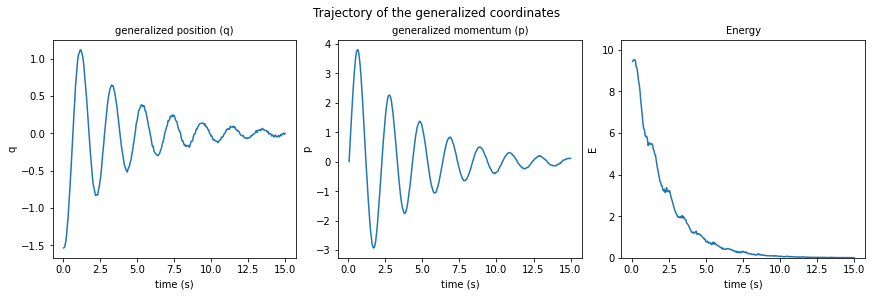

In [9]:
plot_traj_pend(t_eval, q, p, energy) # sanity check 

### Multiple trajectories

In [10]:
def multiple_trajectories(time_steps, num_trajectories, noise_std=0.0, C=0.0, u=0.0, coord_type = 'hamiltonian'):
    '''
    
    '''
    # the first trajectory
    q, p, t_eval = get_trajectory_pend(timesteps=time_steps, radius=None, y0=None, noise_std=noise_std, u=u, rad=True, C=C)
    energy, derivatives = get_energy_pendulum(q,p, u, C)
    energy = energy.squeeze()
    q = q.squeeze()
    if coord_type == 'hamiltonian':
        p = p.squeeze()
    if coord_type == 'newtonian':
        p = derivatives[:,0].squeeze()
        
    derivatives = derivatives.unsqueeze(dim=0)

    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        q_n, p_n, t_eval_n = get_trajectory_pend(timesteps=time_steps, radius=None, y0=None, noise_std=noise_std, u=u, rad=True, C=C)
        energy_n, derivatives_n = get_energy_pendulum(q_n,p_n, u, C)

        energy = torch.vstack((energy, energy_n.squeeze()))
        q = torch.vstack((q, q_n.squeeze()))
        

        if coord_type == 'hamiltonian':
            p = torch.vstack((p, p_n.squeeze()))
            p = p.squeeze()
        if coord_type == 'newtonian':
            p = torch.vstack((p, derivatives_n[:,0].squeeze()))
        
        derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))

    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q = q.unsqueeze(dim=0) 
        p = p.unsqueeze(dim=0) 
        energy = energy.unsqueeze(dim=0) 
    return q.t(), p.t(), t_eval, energy.t(), torch.permute(derivatives, (1,0,2)) #

In [11]:
q, p, t_eval, energy, derivatives = multiple_trajectories(200, 10, noise_std=0.01, C=0.5, coord_type = 'hamiltonian')

In [12]:
shapes = [print(i.shape) for i in [q, p, t_eval, energy, derivatives]]

torch.Size([200, 10])
torch.Size([200, 10])
torch.Size([200])
torch.Size([200, 10])
torch.Size([200, 10, 2])


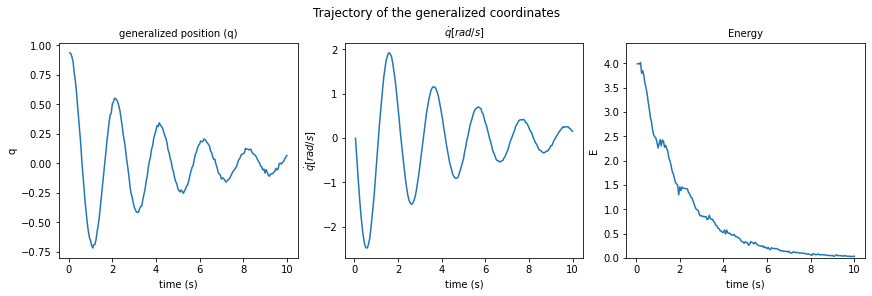

In [13]:
plot_traj_pend(t_eval, q[:,0], derivatives[:,0,0], energy[:,0], coord_type = 'newtonian') # sanity check 
#( will be same as hamiltonian because here m=1 and l=1 )

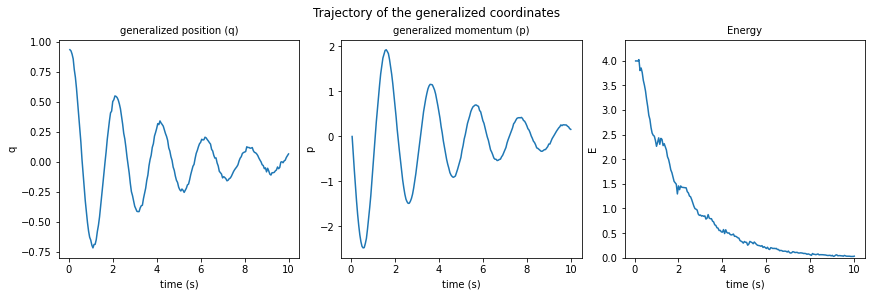

In [14]:
plot_traj_pend(t_eval, q[:,0], p[:,0], energy[:,0], coord_type = 'hamiltonian') # sanity check 

### Dataset & Dataloader

In [15]:
class TrajectoryDataset(Dataset):
    '''
    
    '''
    def __init__(self, q, p, t_eval):
        self.q = q
        self.p = p
        self.t_eval = t_eval

    def __len__(self):
        return self.q.shape[1]

    def __getitem__(self, idx):
        q = self.q[:,idx]
        p = self.p[:,idx]
        t_eval = self.t_eval#[idx].squeeze()
        x = torch.stack((q,p),dim=1)#.t().float()
        return x, t_eval

In [16]:
def data_loader(q, p, t_eval, batch_size, shuffle = True, proportion = 0.5):
    '''
    '''
    # split  into train and test 
    if proportion:

        full_dataset = TrajectoryDataset(q, p, t_eval)

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train, test = random_split(full_dataset, [train_size, test_size])

        # q_train, q_test = train_test_split_torch(q, test_size=proportion, random_state=0)
        # p_train, p_test = train_test_split_torch(p, test_size=proportion, random_state=0)

        # test = TrajectoryDataset(q_test, p_test, t_eval)

        test_loader = DataLoader(
            test,
            batch_size,
            shuffle
            )    
    else:
      train = TrajectoryDataset(q, p, t_eval)
      # if proportion is set to None don't split the dataset
      q_train = q
      p_train = p
      t_eval_train = t_eval
      test_loader = None

    # load the training data into a custom pyotorch dataset
    # train = TrajectoryDataset(q_train, p_train, t_eval)

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

In [17]:
q, p, t_eval,_,_= multiple_trajectories(time_steps=40, 
                                          num_trajectories=20, noise_std=0.01, C=0.5, coord_type = 'newtonian')

In [18]:
train_loader, test_loader = data_loader(q, p, t_eval, batch_size=3, shuffle = True, proportion = 0.5)

In [19]:
# sanity checks
x_tt, t_eval_tt = next(iter(test_loader))
print(x_tt.shape)

torch.Size([3, 40, 2])


In [20]:
# sanity checks
x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)

torch.Size([3, 40, 2])


In [21]:
t_eval_tt.shape

torch.Size([3, 40])

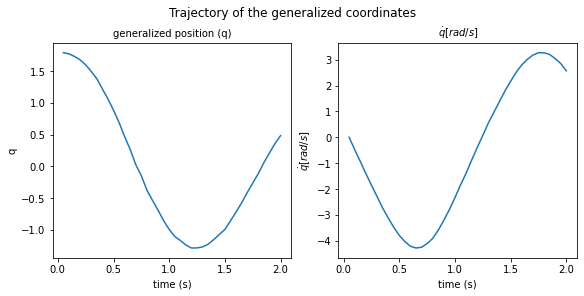

In [22]:
plot_traj_pend(t_eval_tt[0], x_tt[0,:,0], x_tt[0,:,1], coord_type = 'newtonian')

## Utils

In [23]:
def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Models

#### Base models

In [24]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'relu':
        nl = torch.relu
    elif name == 'sigmoid':
        nl = torch.sigmoid
    elif name == 'softplus':
        nl = torch.nn.functional.softplus
    elif name == 'selu':
        nl = torch.nn.functional.selu
    elif name == 'elu':
        nl = torch.nn.functional.elu
    elif name == 'swish':
        nl = lambda x: x * torch.sigmoid(x)
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

In [25]:
class hidden_Layer(torch.nn.Module):
    '''
    A one layer MLP with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x

In [26]:
class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='tanh'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        )
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x, separate_fields=False):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)

In [27]:
model = MLP(input_dim=2, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation='tanh')

In [28]:
count_parameters(model)

8551

### U-ODE-HNN

In [29]:
class U_ODE_HNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module
    Equivalent of unconstrained ODE HNN from the report
    Architecture for input (q, p, u), 
    where q and p are tensors of size (bs, n) and u is a tensor of size (bs, 1)
    '''
    def __init__(self, input_dim, H_net=None, M_net=None, V_net=None, g_net=None, device=None,
                    assume_canonical_coords=True, baseline=True, structure=False):
        super(U_ODE_HNN, self).__init__()
        self.baseline = baseline
        self.structure = structure

        self.H_net = H_net
        self.g_net = g_net

        self.device = device
        self.assume_canonical_coords = assume_canonical_coords

        self.input_dim = input_dim
        
        # add a learnable dissipation coefficient
        self.C_dissip = torch.nn.Parameter(torch.tensor([0.5]))  # torch.nn.Parameter(torch.rand(1))
        self.C_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            q, p = torch.chunk(x,2,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq , dHdp = torch.chunk(dH,2,dim=-1)

            dqdt = dHdp 

            dpdt = -dHdq - self.C_dissip*dHdp

            # symplectic gradient 
            S_h = torch.cat((dqdt, dpdt), 
                            dim=-1) 
            return S_h 

In [30]:
H_net = MLP(input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='tanh')

In [31]:

model = U_ODE_HNN(input_dim=2, H_net=H_net, M_net=None, V_net=None, g_net=None, device=None,
                    assume_canonical_coords=True, baseline=True, structure=False)

In [32]:
s_h = model(t_eval_tt, x_tt) # sanity check
print(s_h.shape)

torch.Size([3, 40, 2])


### Newtonian_U-ODE-HNN

In [33]:
class Newtonian_U_ODE_HNN(torch.nn.Module): 
    '''
    Modified version of the original SymODEN_R module
    Equivalent of unconstrained ODE HNN from the report
    Architecture for input (q, p, u), 
    where q and p are tensors of size (bs, n) and u is a tensor of size (bs, 1)
    '''
    def __init__(self, input_dim, H_net=None, M_net=None, V_net=None, g_net=None, device=None,
                    assume_canonical_coords=True, baseline=True, structure=False):
        super(Newtonian_U_ODE_HNN, self).__init__()
        self.baseline = baseline
        self.structure = structure

        self.H_net = H_net
        self.g_net = g_net

        self.device = device
        self.assume_canonical_coords = assume_canonical_coords

        self.input_dim = input_dim
        
        # add a learnable dissipation coefficient
        self.C_dissip = torch.nn.Parameter(torch.tensor([0.5]))  #torch.nn.Parameter(torch.rand(1))
        self.C_dissip.requires_grad = True

        # Constant representing the 1/ml^2 term
        self.C_ml = torch.nn.Parameter(torch.tensor([1.0])) #torch.nn.Parameter(torch.rand(1))
        self.C_ml.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            q, p = torch.chunk(x,2,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq , dHdp = torch.chunk(dH,2,dim=-1)

            dqdt = self.C_ml*dHdp 

            dpdt = -self.C_ml*dHdq - self.C_dissip*(self.C_ml**2)*dHdp

            # symplectic gradient 
            S_h = torch.cat((dqdt, dpdt), 
                            dim=-1)
            
            return S_h

### L-ODE-NET

Lagrangian ODE-NET NOT COMPLETED

In [ ]:
# class L_ODE_HNN(torch.nn.Module): 
#     '''
#     Modified version of the original SymODEN_R module
#     Equivalent of unconstrained ODE HNN from the report
#     Architecture for input (q, p, u), 
#     where q and p are tensors of size (bs, n) and u is a tensor of size (bs, 1)
#     '''
#     def __init__(self, input_dim, H_net=None, M_net=None, V_net=None, g_net=None, device=None,
#                     assume_canonical_coords=True, baseline=True, structure=False):
#         super(Newtonian_U_ODE_HNN, self).__init__()
#         self.baseline = baseline
#         self.structure = structure

#         self.H_net = H_net
#         self.g_net = g_net

#         self.device = device
#         self.assume_canonical_coords = assume_canonical_coords

#         self.input_dim = input_dim
        
#         # add a learnable dissipation coefficient
#         self.C_dissip = torch.nn.Parameter(torch.tensor([0.5]))  #torch.nn.Parameter(torch.rand(1))
#         self.C_dissip.requires_grad = True

#         # Constant representing the 1/ml^2 term
#         self.C_ml = torch.nn.Parameter(torch.tensor([1.0])) #torch.nn.Parameter(torch.rand(1))
#         self.C_ml.requires_grad = True

#     def forward(self, t, x):
#         with torch.enable_grad():
#             q_p = x

#             q, p = torch.chunk(x,2,dim=-1)

#             q_p.requires_grad_(True)

#             H = self.H_net(q_p)

#             dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

#             dH = dH[0]

#             dHdq , dHdp = torch.chunk(dH,2,dim=-1)

#             dqdt = self.C_ml*dHdp 

#             dpdt = -self.C_ml*dHdq - self.C_dissip*(self.C_ml**2)*dHdp

#             # symplectic gradient 
#             S_h = torch.cat((dqdt, dpdt), 
#                             dim=-1)
            
#             return S_h

### Autoencoder

In [34]:
class Autoencoder(torch.nn.Module):
    '''Just a MLP
    From the SymODEN repository
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=2, dec_in_dim = 2, dec_out_dim = 2, activation='tanh'):
        super(Autoencoder, self).__init__()

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)
        # q,p=torch.split(x,1,dim=2)
        p_hat = self.encoder(x) # coordinates in the latent space

        # z_h = torch.cat((q,z),dim=2) # input known q and encoded z into decoder
        q_dot_hat = self.decoder(p_hat) # coordinates back in the original space but using the decoder

        return p_hat, q_dot_hat

In [35]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=1, dec_in_dim = 1, dec_out_dim = 2, activation='tanh')

In [36]:
count_parameters(autoencoder)

8835

In [ ]:
x_tt.shape

torch.Size([3, 40, 2])

In [ ]:
test = x_tt[:,:5,:]

In [ ]:
test.shape

torch.Size([3, 5, 2])

In [ ]:
test[:,0,:].shape

torch.Size([3, 2])

In [ ]:
z,x = autoencoder(test[:,0,:])

In [ ]:
z

tensor([[-0.0269],
        [-0.0547],
        [-0.0416]], grad_fn=<AddmmBackward0>)

In [ ]:
x

tensor([[0.0984, 0.0463],
        [0.1011, 0.0512],
        [0.0999, 0.0489]], grad_fn=<AddmmBackward0>)

In [ ]:
def train_autoencoder():

    lr = 1e-3
    Ts = 0.05

    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    w=torch.tensor([0.1,1.0], device=device)

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0

        t1 = time.time()

        #horizon = select_horizon(step)

        # Training
        for x, t_eval in iter(train_loader):
            x = torch.permute(x, (1,0,2)) # to have the same dimensions as odeint
            t_eval = t_eval[0,:horizon] #t_eval.squeeze()
           
            train_z, train_x_hat = autoencoder(x)
            train_loss_mini = L2_loss(x[:, :, :], train_x_hat[:],w) # batch loss
            
            train_loss = train_loss + train_loss_mini # epoch loss

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad() 

        t2 = time.time()
        train_time = t2-t1

        # Testing
        if test_loader:
            if not (step%10):
                for x, t_eval in iter(test_loader):
                    x = torch.permute(x, (1,0,2)) 

                    t_eval = t_eval[0,:horizon] # t_eval.squeeze()

                    
                    test_x_hat = odeint(model, x[0, :, :], t_eval, method='rk4', options=dict(step_size=Ts))
                    
                    test_loss_mini = L2_loss(x[:horizon, :, :], test_x_hat[:horizon],w) 
                    test_loss = test_loss + test_loss_mini
                
                print('epoch', step, '| train loss ', train_loss.item(), '| test loss', test_loss.item(), '| train time:',train_time)
                stats['test_loss'].append(test_loss.item())
        else:
            if not (step%10):
                print('epoch', step, '| train loss ', train_loss.item(),'| train time:',train_time)

        # logging
        stats['train_loss'].append(train_loss.item())
        
    return stats

# Training

In [ ]:
def L2_loss(u, v, w):
    return ((u-v)*w).pow(2).mean()

In [ ]:
def load_model(model_name='U_ODE_HNN'):
    H_net = MLP(input_dim=2, hidden_dim=130, output_dim=1, nonlinearity='tanh', bias_bool=True)

    if model_name == 'U_ODE_HNN':
        model = U_ODE_HNN(input_dim=2, H_net=H_net, M_net=None, V_net=None, g_net=None, device=device,
                            assume_canonical_coords=True, baseline=True, structure=False)
    if model_name == 'Newtonian_U_ODE_HNN':
        model = Newtonian_U_ODE_HNN(input_dim=2, H_net=H_net, M_net=None, V_net=None, g_net=None, device=device,
                            assume_canonical_coords=True, baseline=True, structure=False)

    model.to(device)
    return model

In [ ]:
def select_horizon(step, 
                   n1=300, 
                   n2=100, 
                   n3=100,
                   n4=100):
    # n1 number of steps with a horizon =  20
    # n2 number of steps with a horizon =  25
    # n3 number of steps with a horizon =  30
    # n4 number of steps with a horizon =  35
    # horizon = 40 for the remainder of training steps
    if step <=n1:
        horizon = 20
        if step==0:
            print('horizon length :', horizon)
    elif (step > n1)&(step <= n1+n2):
        horizon = 25
        if step==n1+1:
            print('horizon length :', horizon)
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 30
        if step==n1+n2+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 35
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
    else :
        horizon = 40
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
    return horizon

In [ ]:
def train(model, epochs = 20):
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    lr = 1e-3
    Ts = 0.05
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    w=torch.tensor([1.0,1.0], device=device)
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        horizon = select_horizon(step)

        # Training
        for x, t_eval in iter(train_loader):
            x = torch.permute(x, (1,0,2)) # to have the same dimensions as odeint
            t_eval = t_eval[0,:horizon] #t_eval.squeeze()

            train_x_hat = odeint(model, x[0, :, :], t_eval, method='rk4', options=dict(step_size=Ts))            

            train_loss_mini = L2_loss(x[:horizon, :, :], train_x_hat[:horizon],w) # batch loss
            train_loss = train_loss + train_loss_mini # epoch loss = sum of batch losses

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad() 

        t2 = time.time()
        train_time = t2-t1

        # Testing
        if test_loader:
            if not (step%10):
                for x, t_eval in iter(test_loader):
                    x = torch.permute(x, (1,0,2)) 

                    t_eval = t_eval[0,:horizon] # t_eval.squeeze()

                    
                    test_x_hat = odeint(model, x[0, :, :], t_eval, method='rk4', options=dict(step_size=Ts))
                    
                    test_loss_mini = L2_loss(x[:horizon, :, :], test_x_hat[:horizon],w)
                    test_loss = test_loss + test_loss_mini
                
                print('epoch', step, '| train loss ', train_loss.item(), '| test loss', test_loss.item(), '| train time:',train_time)
                stats['test_loss'].append(test_loss.item())
        else:
            if not (step%10):
                print('epoch', step, '| train loss ', train_loss.item(),'| train time:',train_time)

        # logging
        stats['train_loss'].append(train_loss.item())
        
    return stats

In [ ]:
def load_data_device(time_steps=40, num_trajectories=10, C=0.0, proportion = 0, noise_std=0.0, batch_size=100, coord_type = 'hamiltonian'):
    # create trajectories
    q, p, t_eval,_,_ = multiple_trajectories(time_steps=time_steps, 
                                         num_trajectories=num_trajectories, noise_std=noise_std, 
                                         C=C, coord_type = coord_type )

    q=q.to(device) 
    p=p.to(device) 
    t_eval=t_eval.to(device) 

    # dataloader to load data in batches
    train_loader, test_loader = data_loader(q, p, t_eval, batch_size, shuffle = True, proportion = proportion)
    return train_loader, test_loader

In [ ]:
device = 'cpu' # for some reason it is faster on CPU
# probably because the model doesn't have many parameters and the ode solver
# can't do many calculations in parallel ? 

In [ ]:
model = load_model(model_name ='Newtonian_U_ODE_HNN') # Newtonian_U_ODE_HNN U_ODE_HNN
count_parameters(model)
noise_std_1 = 0.00

In [ ]:
train_loader, test_loader = load_data_device(time_steps=40, num_trajectories=200, 
                                             C=0.5, proportion = 0.5, 
                                             noise_std=noise_std_1,batch_size=100, coord_type = 'newtonian')

In [ ]:
stats = train(model, epochs = 1000)

horizon length : 20
epoch 0 | train loss  2.3642396926879883 | test loss 1.829921841621399 | train time: 0.18611931800842285
epoch 10 | train loss  2.119856119155884 | test loss 1.6240828037261963 | train time: 0.18724846839904785
epoch 20 | train loss  1.3461580276489258 | test loss 0.9718426465988159 | train time: 0.18590784072875977
epoch 30 | train loss  0.485720694065094 | test loss 0.39169177412986755 | train time: 0.17557454109191895
epoch 40 | train loss  0.3228217661380768 | test loss 0.2802687883377075 | train time: 0.17296957969665527
epoch 50 | train loss  0.18329550325870514 | test loss 0.1515091061592102 | train time: 0.17633438110351562
epoch 60 | train loss  0.13086996972560883 | test loss 0.10897091031074524 | train time: 0.17919635772705078
epoch 70 | train loss  0.10024242103099823 | test loss 0.08847950398921967 | train time: 0.17970943450927734
epoch 80 | train loss  0.08304678648710251 | test loss 0.07143762707710266 | train time: 0.17694854736328125
epoch 90 | tr

In [ ]:
model.C_dissip 

Parameter containing:
tensor([0.4858], requires_grad=True)

In [ ]:
x, t_eval = next(iter(train_loader)) 
t_eval = t_eval[0,:] 
nums = iter(torch.arange(len(x))) 

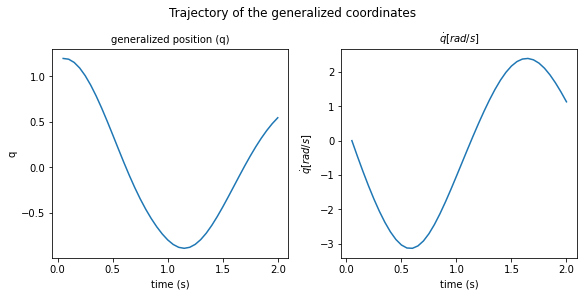

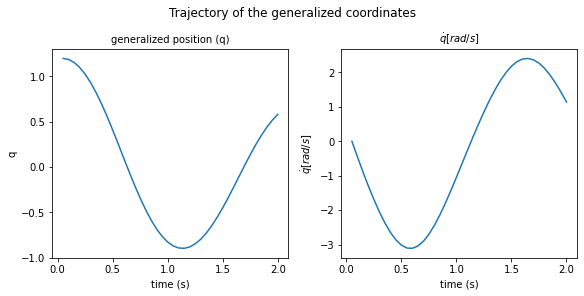

In [ ]:
n = next(nums) 

test_x_hat = odeint(model, x[n, 0, :], t_eval, method='rk4') 

# train trajectory
plot_traj_pend(t_eval.cpu().detach().numpy(), test_x_hat[:,0].cpu().detach().numpy(), 
          test_x_hat[:,1].cpu().detach().numpy(), coord_type = 'newtonian') 

# real trajectory
plot_traj_pend(t_eval.cpu().detach().numpy(), x[n,:,0].cpu().detach().numpy(), 
          x[n,:,1].cpu().detach().numpy(), coord_type = 'newtonian')

In [ ]:
train_loader, test_loader = load_data_device(time_steps=500, num_trajectories=2, C=0.5, proportion = 0.0, noise_std = 0.0) 

In [ ]:
x, t_eval = next(iter(train_loader))
t_eval = t_eval[0,:]
nums = iter(torch.arange(len(x)))

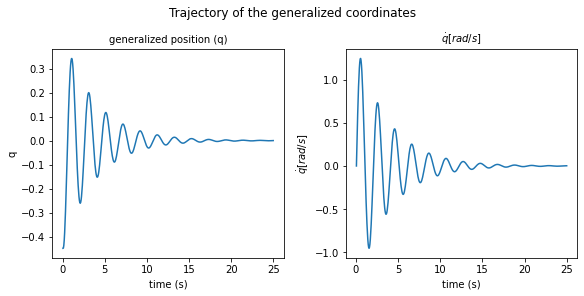

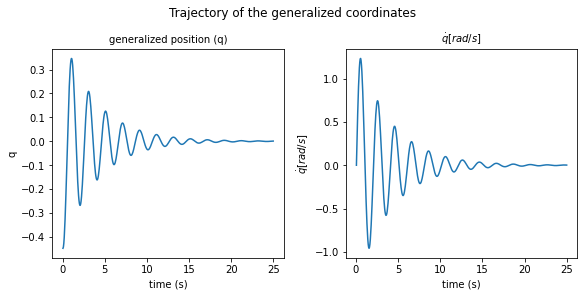

In [ ]:
n = next(nums) 

test_x_hat = odeint(model, x[n, 0, :], t_eval, method='rk4') 

# train trajectory
plot_traj_pend(t_eval.cpu().detach().numpy(), test_x_hat[:,0].cpu().detach().numpy(), 
          test_x_hat[:,1].cpu().detach().numpy(), coord_type = 'newtonian') 

# real trajectory
plot_traj_pend(t_eval.cpu().detach().numpy(), x[n,:,0].cpu().detach().numpy(), 
          x[n,:,1].cpu().detach().numpy(), coord_type = 'newtonian') 